# T012 · Data acquisition from KLIFS

Authors:

- Dominique Sydow, 2019-2020, [Volkamer lab, Charité](https://volkamerlab.org/)
- Jaime Rodríguez-Guerra, 2019-2020, [Volkamer lab, Charité](https://volkamerlab.org/)

## Aim of this talktorial

KLIFS is a database for kinase-ligand interaction fingerprints and structures. In this talktorial, we will use the programmatic access of this database (KLIFS Swagger API) and the `opencadd` package to interact with its rich content. 
First, we will use a query kinase (EGFR) to fetch all available structures and explore their bound ligands and interaction fingerprints. Then, we will explore the bioactivity data for the EGFR inhibitor Gefitinib in order to find off-targets. Last but not least, we offer a convenience function that allows you to easily explore different (if you want random) kinases.

You can also learn more about other webservices like ChEMBL (__Talktorial T001__) or PubChem (__Talktorial T013__).

### Contents in *Theory*

- Kinases
- KLIFS database
- KLIFS Swagger API
- `opencadd`

### Contents in *Practical*

- Define kinase and ligand of interest: EGFR and Gefitinib
- Generate a KLIFS Python client
- Explore the KLIFS Swagger API
  - Kinase groups
  - Kinase families
  - Kinases
  - Structures
  - Interaction fingerprints
  - Structure coordinates
  - Ligands
- Case study: EGFR (using `opencadd`)
  - Get all structures for EGFR
  - Average interaction fingerprint
  - Select an example EGFR-Gefitinib structure
  - Show the structure with `nglview`
  - Show all kinase-bound ligands with `rdkit`
  - Explore profiling data for Gefitinib
- Explore random kinase in KLIFS (show example structure and all bound ligands)

### References

* Kinase-centric computational drug development ([_Annu. Rep. Med. Chem._ (2017), __50__, 197-236](https://www.sciencedirect.com/science/article/pii/S0065774317300040?via%3Dihub))
* KLIFS - a kinase-inhibitor interactions database
   * Main database/website reference ([_Nucleic Acids Res._ (2020)](https://academic.oup.com/nar/advance-article/doi/10.1093/nar/gkaa895/5934416))
   * Introduction of the KLIFS website & database ([_Nucleic Acids Res._ (2016), __44__, 6, D365–D371](https://doi.org/10.1093/nar/gkv1082))
   * Initial KLIFS dataset, binding mode classification, residue numbering ([_J. Med. Chem._ (2014), __57__, 2, 249-277](https://pubs.acs.org/doi/abs/10.1021/jm400378w))
* NGLView, the interactive molecule visualizer ([_Bioinformatics_ (2018), __34__, 1241–124](https://doi.org/10.1093/bioinformatics/btx789))

## Theory

### Kinases

Protein kinases are one the most important and well-studied drug targets, since they are critical to most aspects of cell life and their dysregulation causes many diseases such as cancer, inflammation, and autoimmune disorders.

There are 518 protein kinases encoded in the human genome, which were clustered based on their sequence into eight main kinase groups (AGC, CAMK, CK1, CMGC, STE, TK, TKL and Other). Each kinase group is further categorized into different kinase families. Protein kinases catalyze the phosphorylation of tyrosine, serine and theorine residues of themselves or other kinases using their bound ATP. Their binding site is highly conserved based on their sequence and structure, making them difficult drug targets when it comes to the development of selective drugs.

Since this protein class is so well-studied, the amount of available data is growing more and more, allowing and requiring infrastructures that organize, analyze, and provide this data to facilitate kinase-centric drug development ([_Annu. Rep. Med. Chem._ (2017), __50__, 197-236](https://www.sciencedirect.com/science/article/pii/S0065774317300040?via%3Dihub)). One of these rich resources is the KLIFS database, which will be used in this talktorial.

### KLIFS database

The __K__inase-__L__igand __I__nteraction __F__ingerprints and __S__tructures database (KLIFS) is a database that provides information about the protein structure (collected from the PDB) of catalytic kinase domains and the interaction with their ligands. 

* Role: Kinase-ligand interaction profiles database
* Website: http://klifs.net/
* API: Yes, REST-based, Swagger-enabled. No official client. Use `bravado`.
* Documentation: http://klifs.net/swagger/
* Literature:
   * Main database/website reference ([_Nucleic Acids Res._ (2020)](https://academic.oup.com/nar/advance-article/doi/10.1093/nar/gkaa895/5934416))
   * Introduction of the KLIFS website & database ([_Nucleic Acids Res._ (2016), __44__, 6, D365–D371](https://doi.org/10.1093/nar/gkv1082))
   * Initial KLIFS dataset, binding mode classification, residue numbering ([_J. Med. Chem._ (2014), __57__, 2, 249-277](https://pubs.acs.org/doi/abs/10.1021/jm400378w))
    

> Kinase-Ligand Interaction Fingerprints and Structures database (KLIFS), developed at the Division of Medicinal Chemistry - VU University Amsterdam, is a database that revolves around the protein structure of catalytic kinase domains and the way kinase inhibitors can interact with them. Based on the underlying systematic and consistent protocol all (currently human and mouse) kinase structures and the binding mode of kinase ligands can be directly compared to each other. Moreover, because of the classification of an all-encompassing binding site of 85 residues it is possible to compare the interaction patterns of kinase-inhibitors to each other to, for example, identify crucial interactions determining kinase-inhibitor selectivity.

### KLIFS Swagger API

The KLIFS database offers standardized URL schemes (__REST API__) to programmatically access - from your computer - resources that live on the KLIFS server. You could literally paste such an URL into your browser (sending a __request__) and you would get back a result (receiving a __response__). For example, the following URL will fetch from KLIFS all ChEMBL bioactivity values associated with the kinase inhibitor Gefitinib (ligand expo ID in the PDB: IRE):

https://klifs.net/api/bioactivity_list_pdb?ligand_PDB=IRE

Now, it would be possible to generate these URL schemes with your own little script or library (__client__), but it would _really_ be nicer if you would not need to deal with the technical details of how to set up such an URL. 
Luckily, there is a solution - some websites provide you with a document that defines the REST API schema for you (__Swagger definitions__). 
Luckily again, KLIFS is one of them! 

- Take a look at how such a document looks like in case of KLIFS (it's a json file): https://klifs.net/swagger/swagger.json 
- You can also explore the definitions interactively using Swagger's user interface (Swagger UI): http://klifs.net/swagger/

We are getting closer. We know now that we can get KLIFS results using URLs and we know thanks to the KLIFS Swagger definitions how these URLs need to look like. 
What we are still missing is a nice Python program (client) that offers a simple Python API to send these requests and receive the responses - under the hood - for us.

We are lucky once more. Libraries like `bravado` can be used to generate dynamically such a Python client based on Swagger definitions - for our webservice at hand here, `bravado` can be used to generate a KLIFS client based on the KLIFS Swagger definitions. This KLIFS client will offer many different methods to interact with the KLIFS webservice (as defined by the Swagger definitions). In the "Practical" section of this talktorial, we will revisit these steps!

### `opencadd`

`opencadd` is a Python library for structural cheminformatics developed by the Volkamber lab at the Charité in Berlin. 
This library is a growing collection of modules that help facilitate and standardize common tasks in structural bioinformatics and cheminformatics, e.g. a module for structural superimposition (`opencadd.structure.superpsition`) or KLIFS queries (`opencadd.databases.klifs`).

- GitHub repository: https://github.com/volkamerlab/opencadd
- Documentation: https://opencadd.readthedocs.io

We will use the KLIFS-dedicated module in this talktorial. It offers a standardized API to work with KLIFS data locally (KLIFS download) or remotely (KLIFS Swagger API). Most query results are returned in the form of standardized `pandas` DataFrames for quick and easy data manipulation.

## Practical

Let's get started! For starters, we will define our kinase and ligand of interest (EGFR and Gefitinib) - and then we will explore their KLIFS data using first the KLIFS Swagger API and then using `opencadd`'s KLIFS module.

In [42]:
from bravado.client import SwaggerClient
from IPython.display import display, Markdown
import pandas as pd
import nglview as nv
from rdkit import Chem
from rdkit.Chem.Draw import (
    IPythonConsole,
    MolsToGridImage,
)  # Needed to show molecules
import opencadd

# To be replaced by an opencadd import, once https://github.com/volkamerlab/opencadd/pull/57 is closed
from utils import mprint, hprint

# Show up to 50 columns for DataFrames in this talktorial
pd.set_option("display.max_columns", 50)

### Define kinase and ligand of interest: EGFR and Gefitinib

Adapted from [the corresponding Wikipedia article](https://en.wikipedia.org/wiki/Epidermal_growth_factor_receptor):

>The epidermal growth factor receptor (EGFR) is a member of the ErbB family of receptors, a subfamily of four closely related receptor tyrosine kinases: EGFR (ErbB-1), HER2/neu (ErbB-2), Her 3 (ErbB-3) and Her 4 (ErbB-4). In many cancer types, mutations affecting EGFR expression or activity could result in cancer.
>
>Deficient signaling of the EGFR and other receptor tyrosine kinases in humans is associated with diseases such as Alzheimer's, while over-expression is associated with the development of a wide variety of tumors. Interruption of EGFR signalling, either by blocking EGFR binding sites on the extracellular domain of the receptor or by inhibiting intracellular tyrosine kinase activity, can prevent the growth of EGFR-expressing tumours and improve the patient's condition.


As a result, we are interested in finding potential inhibitors that can target members of the EGFR family. Gefitinib is an already approved EGFR inhibitor [PubChem](https://pubchem.ncbi.nlm.nih.gov/compound/Gefitinib) with the ligand Expo ID "IRE".

In [2]:
species = "Human"
kinase_group = "TK"
kinase_family = "EGFR"
kinase_name = "EGFR"
ligand_expo_id = "IRE"

### Generate a KLIFS Python client

First, we will generate a KLIFS Python client using the provided KLIFS Swagger definitions.

In [3]:
KLIFS_API_DEFINITIONS = "https://klifs.net/swagger/swagger.json"
KLIFS_CLIENT = SwaggerClient.from_url(KLIFS_API_DEFINITIONS, config={"validate_responses": False})

As with any Python library, you can access the KLIFS client's entry points when hitting the Tab key after 

```python
KLIFS_CLIENT.
```

Available entry points are: 

- `KLIFS_CLIENT.Information`: Access to kinases (name, group, family, ...).
- `KLIFS_CLIENT.Interactions`: Access to kinase-ligand interaction fingerprints.
- `KLIFS_CLIENT.Ligands`: Access to kinase-bound ligands (name, SMILES, ...) and their measured bioactivity against kinases (ChEMBL data).
- `KLIFS_CLIENT.Structures`: Access to kinase structures with and without ligands (including their KLIFS-processed PDB data).

### Explore the KLIFS Swagger API

Let's send a few requests to KLIFS to explore available data for our kinase and ligand of interest.

#### 1. Kinase groups

Let's check out the available kinase groups.

In [4]:
kinase_groups = KLIFS_CLIENT.Information.get_kinase_groups().response().result
# Note we are using the function mprint here, which allows us to print text in Markdown style :)
mprint("All kinase groups are returned as a list of strings:")
print(kinase_groups)
# NBVAL_CHECK_OUTPUT

All kinase groups are returned as a list of strings:

['AGC', 'CAMK', 'CK1', 'CMGC', 'Other', 'STE', 'TK', 'TKL']


#### 2. Kinase families

Now let's look at our all available kinase families for the kinase group of interest (`kinase_group`).

In [5]:
# Note: All code lines are supposed to be not longer than 99 characters
# Thus, sometimes brackets are used so that code lines can be split to multiple lines
# (you could also write this in one line without the brackets!)
kinase_families = (
    KLIFS_CLIENT.Information.get_kinase_families(kinase_group=kinase_group).response().result
)
mprint(f"Kinase families in {kinase_group} are returned as a list of strings:")
print(kinase_families)

Kinase families in TK are returned as a list of strings:

['ALK', 'Abl', 'Ack', 'Alk', 'Axl', 'CCK4', 'Csk', 'DDR', 'EGFR', 'Eph', 'FAK', 'FGFR', 'Fer', 'InsR', 'JakA', 'JakB', 'Lmr', 'Met', 'Musk', 'PDGFR', 'Ret', 'Ror', 'Ryk', 'Sev', 'Src', 'Syk', 'TK-Unique', 'Tec', 'Tie', 'Trk', 'VEGFR']


#### 3. Kinases

The following kinases belong to the kinase family of interest (`kinase_family`):

In [6]:
kinases = (
    KLIFS_CLIENT.Information.get_kinase_names(kinase_family=kinase_family, species=species)
    .response()
    .result
)
mprint(
    f"Kinases in the {species.lower()} family {kinase_family} as a list of objects that contain kinase-specific information:"
)
kinases

Kinases in the human family EGFR as a list of objects that contain kinase-specific information:

[IDlist(full_name='epidermal growth factor receptor', kinase_ID=406, name='EGFR', species='Human'),
 IDlist(full_name='erb-b2 receptor tyrosine kinase 2', kinase_ID=407, name='ERBB2', species='Human'),
 IDlist(full_name='erb-b2 receptor tyrosine kinase 3', kinase_ID=408, name='ERBB3', species='Human'),
 IDlist(full_name='erb-b2 receptor tyrosine kinase 4', kinase_ID=409, name='ERBB4', species='Human')]

In this talktorial we are interested in the kinase defined in `kinase_name`. 
Let extract the KLIFS ID for this kinase, which we will use to query for structures in KLIFS.

In [7]:
kinase_klifs_id = [kinase.kinase_ID for kinase in kinases if kinase.name == kinase_name][0]
mprint(f"Kinase KLIFS ID for {kinase_name}: {kinase_klifs_id}")
# NBVAL_CHECK_OUTPUT

Kinase KLIFS ID for EGFR: 406

#### 4. Structures

We get all available __structures__ in KLIFS for this kinase and show details for example ligand-bound structure.

In [8]:
structures = (
    KLIFS_CLIENT.Structures.get_structures_list(kinase_ID=[kinase_klifs_id]).response().result
)
mprint(f"Number of structures for the kinase {kinase_name}: {len(structures)}")
mprint(f"Example structure, i.e. the first structure in the result list that contains a ligand:")
# If structures do not contain ligands, the ligand field is set to 0
structure = [structure for structure in structures if structure.ligand != 0][0]
structure

Number of structures for the kinase EGFR: 425

Example structure, i.e. the first structure in the result list that contains a ligand:

structureDetails(DFG='in', Grich_angle=48.1597, Grich_distance=14.8202, Grich_rotation=43.046, aC_helix='out', allosteric_ligand=0, alt='A', back=True, bp_III=False, bp_II_A_in=True, bp_II_B=False, bp_II_B_in=False, bp_II_in=True, bp_II_out=False, bp_IV=False, bp_I_A=True, bp_I_B=True, bp_V=False, chain='A', fp_I=False, fp_II=False, front=True, gate=True, kinase='EGFR', kinase_ID=406, ligand='W19', missing_atoms=0, missing_residues=0, pdb='3w33', pocket='KVLGSGAFGTVYKVAIKELEILDEAYVMASVDPHVCRLLGIQLITQLMPFGCLLDYVREYLEDRRLVHRDLAARNVLVITDFGLA', quality_score=8.0, resolution=1.7, rmsd1=0.814, rmsd2=2.153, species='Human', structure_ID=782)

As you can see for the example structure, KLIFS provides the following information about:
- the kinase that this structure represents and its pocket sequence
- the bound ligand including details on the subpockets that the ligand occupies
- the structure quality and conformation

Based on an initial analysis of over 1200 kinase-ligand crystal structures, the KLIFS authors defined a pocket that comprises 85 residues and covers interactions seen in the kinase-ligand structures. For our example the pocket sequence is the following:

In [9]:
mprint(f"Pocket sequence: {structure.pocket} ({len(structure.pocket)} residues)")

Pocket sequence: KVLGSGAFGTVYKVAIKELEILDEAYVMASVDPHVCRLLGIQLITQLMPFGCLLDYVREYLEDRRLVHRDLAARNVLVITDFGLA (85 residues)

#### 5. Interaction fingerprints

Next, we get the interaction fingerprint (IFP) the example kinase-ligand complex structure. The KLIFS IFP checks for each of the 85 residues if the following 7 interaction between that residue and the ligand is available (1) or not (0). 

In [10]:
KLIFS_CLIENT.Interactions.get_interactions_get_types().response().result

[{'position': '1', 'name': 'Apolar contact'},
 {'position': '2', 'name': 'Aromatic face-to-face'},
 {'position': '3', 'name': 'Aromatic edge-to-face'},
 {'position': '4', 'name': 'Hydrogen bond donor (protein)'},
 {'position': '5', 'name': 'Hydrogen bond acceptor (protein)'},
 {'position': '6', 'name': 'Protein cation - ligand anion'},
 {'position': '7', 'name': 'Protein anion - ligand cation'}]

This results in an IFP with $85 \cdot 7 = 595$ bits. Let's look at the IFP for our example structure:

In [11]:
structure_klifs_id = structure.structure_ID
interaction_fingerprints = (
    KLIFS_CLIENT.Interactions.get_interactions_get_IFP(structure_ID=[structure_klifs_id])
    .response()
    .result
)
interaction_fingerprints

[{'structure_ID': 782,
  'IFP': '0000000000000010000001000000000000000000000000000000000000000000000000100000000000000000000000000010000001000000100000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000010000001000000100000000000000000000000000000000001000000100000010000001000000100000010011000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000100000010000001010000000000010000000000000'}]

Further below in this talktorial, we will show a quick example of how you could use this IFP information.

#### 6. Structure coordinates

We explored so far a lot the structure properties. Let's get the actual structural data for this first structure in the form of a string that contains the atomic coordinates for the kinase-ligand complex. Show only the first 10 file rows.

In [12]:
complex_coordinates = (
    KLIFS_CLIENT.Structures.get_structure_get_pdb_complex(structure_ID=structures[0].structure_ID)
    .response()
    .result
)
# Show some example rows
complex_coordinates.split("\n")[100:110]

['ATOM     67  N   GLU A 709      18.017  26.733  45.799  1.00  0.00           N  ',
 'ATOM     68  CA  GLU A 709      17.685  25.527  46.562  1.00  0.00           C  ',
 'ATOM     69  C   GLU A 709      17.372  25.814  48.036  1.00  0.00           C  ',
 'ATOM     70  O   GLU A 709      16.634  25.071  48.672  1.00  0.00           O  ',
 'ATOM     71  CB  GLU A 709      18.816  24.503  46.474  1.00  0.00           C  ',
 'ATOM     72  CG  GLU A 709      18.851  23.724  45.177  1.00  0.00           C  ',
 'ATOM     73  CD  GLU A 709      19.877  22.613  45.199  1.00  0.00           C  ',
 'ATOM     74  OE1 GLU A 709      19.470  21.427  45.212  1.00  0.00           O  ',
 'ATOM     75  OE2 GLU A 709      21.088  22.925  45.212  1.00  0.00           O1-',
 'ATOM     76  N   THR A 710      17.928  26.893  48.572  1.00  0.00           N  ']

#### 7. Ligands

Last but not least, let's have quick look at another important resource in KLIFS. For each ligand, it is possible to extract all bioactivities measured for different kinases. The bioactivity data comes from ChEMBL, a manually curated database of bioactive molecules with drug-like properties (check out __Talktorial T001__ for more information about ChEMBL).

In [13]:
bioactivities = (
    KLIFS_CLIENT.Ligands.get_bioactivity_list_pdb(ligand_PDB=structure.ligand).response().result
)
mprint(f"Number of bioactivity values for example ligand {structure.ligand}: {len(bioactivities)}")
mprint(f"Example bioactivity:")
bioactivities[0]

Number of bioactivity values for example ligand W19: 10

Example bioactivity:

{'pref_name': 'Dual specificity mitogen-activated protein kinase kinase 5',
 'accession': 'Q13163',
 'organism': 'Homo sapiens',
 'standard_type': 'IC50',
 'standard_relation': '=',
 'standard_value': '870.0',
 'standard_units': 'nM',
 'pchembl_value': '6.06'}

### Case study: EGFR (using `opencadd`)

After introducing the KLIFS Swagger API above, we will use now the `opencadd.databases.klifs` module, which is a wrapper for this KLIFS client. 
As mentioned in the _Theory_ section of this talktorial, this module returns all responses as `pandas` DataFrames for easy and quick manipulation.

In [14]:
from opencadd.databases.klifs import setup_remote

session = setup_remote()

INFO:opencadd.databases.klifs.api:Set up remote session...
INFO:opencadd.databases.klifs.api:Remote session is ready!


#### 1. Get all structures for EGFR

In [15]:
structures = session.structures.by_kinase_klifs_id(kinase_klifs_id)
mprint(f"Number of structures for the kinase {kinase_name}: {len(structures)}")

Number of structures for the kinase EGFR: 425

In [16]:
structure_klifs_ids = structures["structure.klifs_id"].to_list()
interaction_fingerprints = session.interactions.by_structure_klifs_id(structure_klifs_ids)
mprint(f"Number of IFPs for {kinase_name}: {len(interaction_fingerprints)}")
mprint("Show example IFPs:")
interaction_fingerprints.head()

Number of IFPs for EGFR: 383

Show example IFPs:

,structure.klifs_id,interaction.fingerprint
0,775,0000000000000010000000000000000000000000000000...
1,777,0000000000000010000001000000000000000000000000...
2,778,0000000000000010000000000000000000000000000000...
3,779,0000000000000010000001000000000000000000000000...
4,781,0000000000000010000001000000000000000000000000...


#### 2. Average interaction fingerprint

Let's aggregate the information about interaction types per residues position from all ligand-bound structures that are available for our kinase of interest. 

In [17]:
def average_n_interactions_per_residue(structure_klifs_ids):
    """
    Generate residue position x interaction type matrix that contains the average number of interactions per residue and interaction type.

    Parameters
    ----------
    structure_klifs_ids : list of int
        Structure KLIFS IDs.

    Returns
    -------
    pandas.DataFrame
        Average number of interactions per residue (rows) and interaction type (columns).
    """

    # Get IFP (is returned from KLIFS as string)
    ifps = session.interactions.by_structure_klifs_id(structure_klifs_ids)
    # Split string into list of int (0, 1): structures x IFP bits matrix
    ifps = pd.DataFrame(ifps["interaction.fingerprint"].apply(lambda x: list(x)).to_list())
    ifps = ifps.astype("int32")
    # Sum up all interaction per bit position and normalize by number of IFPs
    ifp_relative = (ifps.sum() / len(ifps)).to_list()
    # Transform aggregated IFP into residue position x interaction type matrix
    residue_feature_matrix = pd.DataFrame(
        [ifp_relative[i : i + 7] for i in range(0, len(ifp_relative), 7)], index=range(1, 86)
    )
    # Add interaction type names
    residue_feature_matrix.columns = session.interactions.interaction_types[
        "interaction.name"
    ].to_list()
    return residue_feature_matrix

In [18]:
residue_feature_matrix = average_n_interactions_per_residue(structure_klifs_ids)
mprint(
    f"Calculated average interactions per interaction type (feature) and residue position:\n"
    f"- __Interaction types__ (columns): {', '.join(residue_feature_matrix.columns)}\n"
    f"- __Residue positions__ (rows): {residue_feature_matrix.index}"
)
# NBVAL_CHECK_OUTPUT

Calculated average interactions per interaction type (feature) and residue position:<br />- __Interaction types__ (columns): Apolar contact, Aromatic face-to-face, Aromatic edge-to-face, Hydrogen bond donor (protein), Hydrogen bond acceptor (protein), Protein cation - ligand anion, Protein anion - ligand cation<br />- __Residue positions__ (rows): RangeIndex(start=1, stop=86, step=1)

In [19]:
residue_feature_matrix.head()

,Apolar contact,Aromatic face-to-face,Aromatic edge-to-face,Hydrogen bond donor (protein),Hydrogen bond acceptor (protein),Protein cation - ligand anion,Protein anion - ligand cation
1,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.992167,0.0,0.0,0.0,0.005222,0.0,0.0
4,0.686684,0.0,0.0,0.0,0.000000,0.0,0.0
5,0.347258,0.0,0.0,0.0,0.000000,0.0,0.0


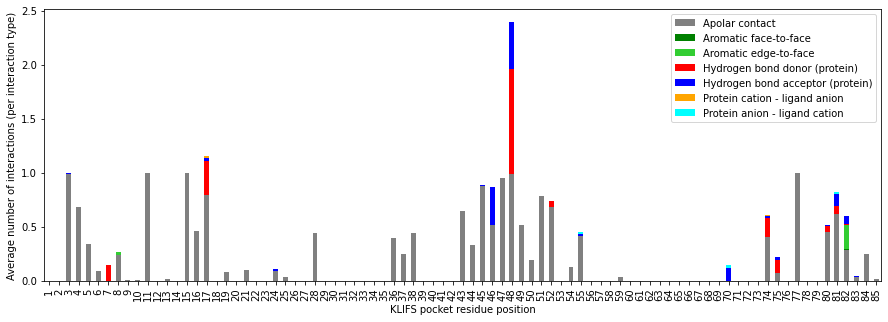

In [20]:
residue_feature_matrix.plot.bar(
    figsize=(15, 5),
    stacked=True,
    xlabel="KLIFS pocket residue position",
    ylabel="Average number of interactions (per interaction type)",
    color=["grey", "green", "limegreen", "red", "blue", "orange", "cyan"],
);

The apolar contacts nicely show which residues are in close contact with the mainly hydrophobic ligand. Most ligands show hydrogen bonding at position 48, which is part of the binding site's hinge region, a key region for kinase-ligand binding.

#### 3. Select an example EGFR-Gefitinib structure 

Keep only structures bound by a ligand of interest (`ligand_expo_id`), sort them by highest resolution and keep show the top 10 structures.

In [21]:
structures[(structures["ligand.expo_id"] == ligand_expo_id)].sort_values(
    by="structure.resolution"
).head(10)

,structure.klifs_id,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.family,kinase.group,structure.pocket,ligand.expo_id,ligand_allosteric.expo_id,ligand.name,ligand_allosteric.name,structure.dfg,structure.ac_helix,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,structure.rmsd1,structure.rmsd2,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath
42,823,4i22,-,A,Human,406,EGFR,None,None,KVLGSGAFGTVYKVAIKELEILDEAYVMASVDPHVCRLLGIQLIMQ...,IRE,-,None,None,in,out,1.71,8.0,0,0,0.810,2.159,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False,14.6390,47.5394,47.9735,None
47,837,4wkq,B,A,Human,406,EGFR,None,None,KVLGSG___TVYKVAIKE_EILDEAYVMASVDPHVCRLLGIQLITQ...,IRE,-,None,None,in,in,1.85,6.7,5,13,0.776,1.995,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False,0.0000,0.0000,0.0000,None
93,889,4wkq,A,A,Human,406,EGFR,None,None,KVLGSG___TVYKVAIKE_EILDEAYVMASVDPHVCRLLGIQLITQ...,IRE,-,None,None,in,in,1.85,6.7,5,13,0.776,1.995,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False,0.0000,0.0000,0.0000,None
23,819,3ug2,B,A,Human,406,EGFR,None,None,KVLSSG___TVYKVAIKE_EILDEAYVMASVDPHVCRLLGIQLIMQ...,IRE,-,None,None,in,in,2.50,7.6,4,8,0.778,2.014,True,True,True,False,False,True,True,False,False,False,False,False,False,False,False,0.0000,0.0000,0.0000,None
98,898,3ug2,A,A,Human,406,EGFR,None,None,KVLSSG___TVYKVAIKE_EILDEAYVMASVDPHVCRLLGIQLIMQ...,IRE,-,None,None,in,in,2.50,7.6,4,8,0.778,2.014,True,True,True,False,False,True,True,False,False,False,False,False,False,False,False,0.0000,0.0000,0.0000,None
18,789,2itz,-,A,Human,406,EGFR,None,None,KVLGSGAFGTVYKVAIKELEILDEAYVMASVDPHVCRLLGIQLITQ...,IRE,-,None,None,in,in,2.72,9.4,0,6,0.776,2.097,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False,18.0567,58.1317,30.0730,None
2,783,2ito,-,A,Human,406,EGFR,None,None,KVLSSGAFGTVYKVAIKELEILDEAYVMASVDPHVCRLLGIQLITQ...,IRE,-,None,None,in,in,3.25,8.0,0,0,0.778,2.096,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False,19.7766,63.3167,23.7491,None
20,790,2ity,-,A,Human,406,EGFR,None,None,KVLGSGAFGTVYKVAIKELEILDEAYVMASVDPHVCRLLGIQLITQ...,IRE,-,None,None,in,in,3.42,8.0,0,0,0.778,2.103,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False,19.5474,62.9767,21.9343,None


In [22]:
structure_klifs_id = (
    structures[(structures["ligand.expo_id"] == ligand_expo_id)]
    .sort_values(by="structure.resolution")
    .iloc[0]["structure.klifs_id"]
)
mprint(
    f"Structure KLIFS ID for best resolved {ligand_expo_id}-bound {kinase_name}: {structure_klifs_id}"
)

Structure KLIFS ID for best resolved IRE-bound EGFR: 823

#### 4. Show the structure with `nglview`

Let's preview the protein-ligand complex and protein with `nglview`.

In [23]:
def show_molecule(structure_text, extension="mol2"):
    """
    Show molecule with the nglview.

    Parameters
    ----------
    structure_text : str
        Structural data in the form of a string.
    extension : str
        Format of the structural data (default: mol2).

    Returns
    -------
    nglview.widget.NGLWidget
        Molecular viewer.
    """

    v = nv.NGLWidget()
    v.add_component(structure_text, ext=extension)
    return v

Let's check what kind of structural data we can get from the KLIFS database.

In [24]:
structure_text = session.coordinates.to_text(structure_klifs_id, "complex", "pdb")
v = show_molecule(structure_text, "pdb")
v

NGLWidget()

In [25]:
v.render_image();

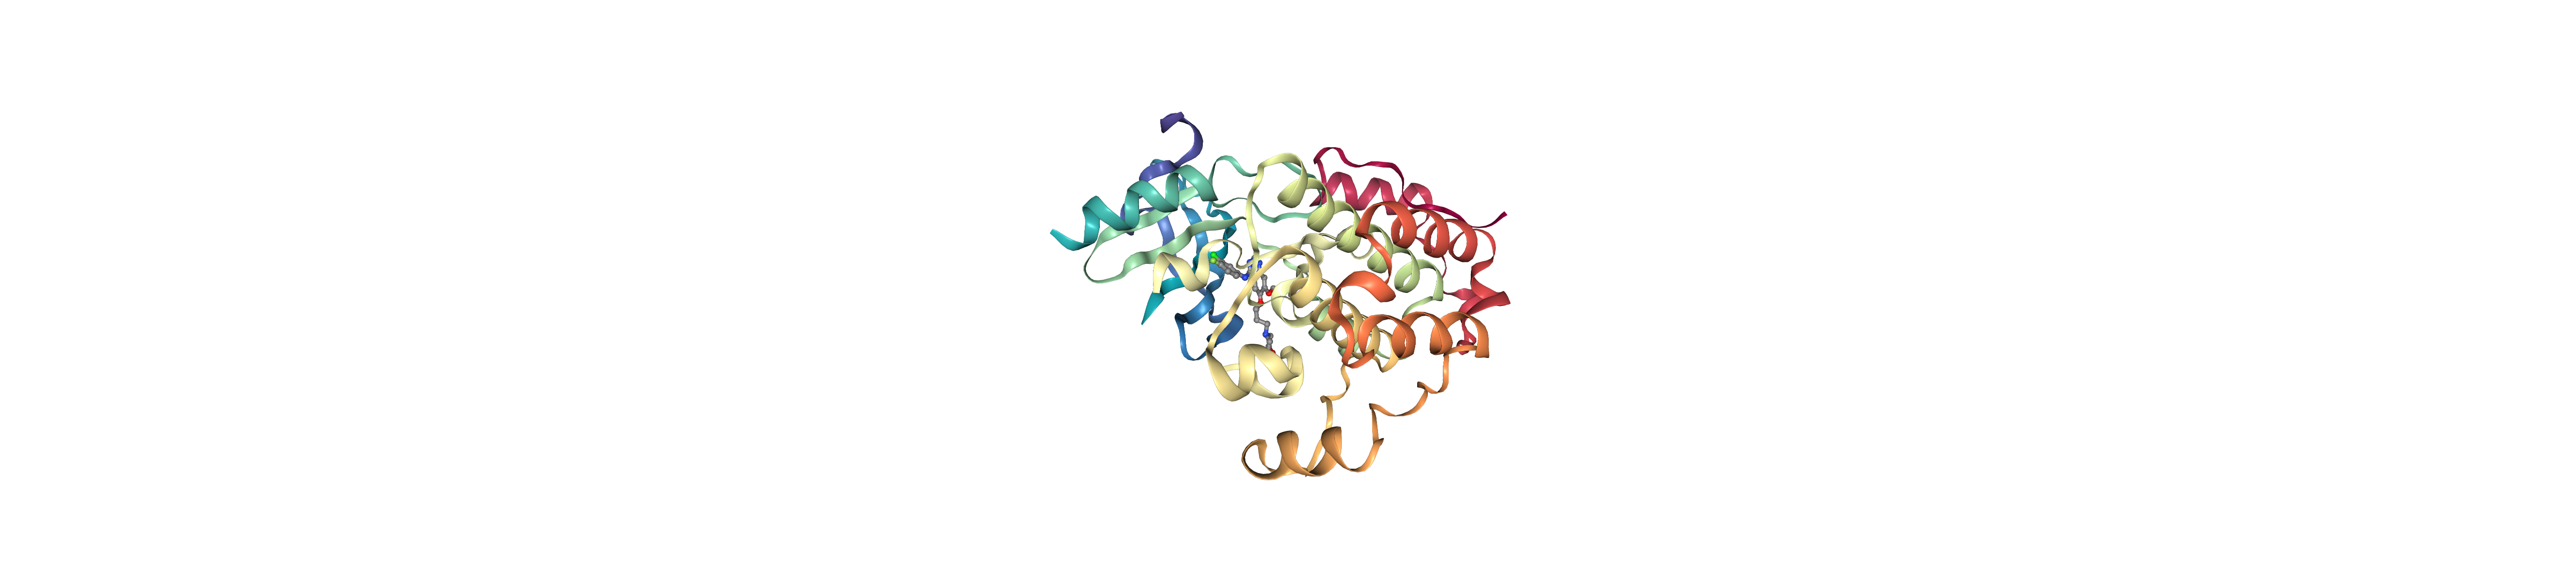

In [26]:
v._display_image()

Let's highlight residues with frequent interactions (across all IFPs for a kinase with `kinase_klifs_id`, in our case kinase EGFR) in an example structure with `structure_klifs_id`. Define with `features`, which feature types you would like to look at, and with `feature_cutoff`, which cutoff to use for highlighting (`None` means you will see any residue that has shown at least one interaction across all structures).

In [27]:
def show_kinase_feature_positions(
    kinase_klifs_id, structure_klifs_id, features=["HBD"], feature_cutoff=None
):
    """
    Show an example kinase structure and color residues showing interactions of defined type(s)
    across interaction fingerprints for this kinase.

    Parameters
    ----------
    kinase_klifs_id : int
        Kinase KLIFS ID used to fetch all associated IFPs.
    structure_klifs_id : int
        Structure KLIFS ID used to map average feature coverage per residue.
    features : list of str
        One or more feature types (H, AR.f2f, AR.e2f, HBD, HBA, NI, PI).
    feature_cutoff : int or float
        Show only residues with a higher average feature coverage than this cutoff.

    Returns
    -------
    nglview.widget.NGLWidget
        Molecular viewer.
    """

    # Get all structures KLIFS ID for a kinase
    structures = session.structures.by_kinase_klifs_id(kinase_klifs_id)
    structure_klifs_ids = structures["structure.klifs_id"].to_list()
    # Get aggregated residue-feature matrix from IFPs
    residue_feature_matrix = average_n_interactions_per_residue(structure_klifs_ids)
    residue_feature_matrix.columns = "H AR.f2f AR.e2f HBD HBA NI PI".split()
    # Aggregate hydrogen bond donor/acceptor values
    residues_features = residue_feature_matrix[features].sum(axis=1)
    # Fetch the PDB residue numbers for the 85 pocket residues
    residues_features.index = session.pockets.by_structure_klifs_id(structure_klifs_id)[
        "residue.id"
    ]
    # Keep only residues with hydrogen bonding above a cutoff occurrence
    if feature_cutoff:
        residues_features = residues_features[residues_features > feature_cutoff]
    # Prepare residue-color mapping in a nglview-required format
    color_scheme_list = [["magenta", residue_id] for residue_id, _ in residues_features.items()]
    color_scheme = nv.color._ColorScheme(color_scheme_list, label="HBA and HBD interactions")
    structure_text = session.coordinates.to_text(structure_klifs_id, "complex", "pdb")
    ligand_expo_id = session.structures.by_structure_klifs_id(structure_klifs_id).iloc[0][
        "ligand.expo_id"
    ]
    v = show_molecule(structure_text, "pdb")
    v.clear()
    v.add_representation("cartoon", selection="protein", color=color_scheme)
    v.add_representation("ball+stick", selection=ligand_expo_id)
    return v

In [35]:
features = ["HBD", "HBA"]
feature_cutoff = 0.25
mprint(
    f"Show residues with interactions {features} for kinase #{kinase_klifs_id} on structure #{structure_klifs_id} that have been seen in at least {feature_cutoff} of all structures."
)
v = show_kinase_feature_positions(
    kinase_klifs_id, structure_klifs_id, features=["HBD", "HBA"], feature_cutoff=0.25
)
v

Show residues with interactions ['HBD', 'HBA'] for kinase #406 on structure #823 that have been seen in at least 0.25 of all structures.

NGLWidget()

In [36]:
v.render_image();

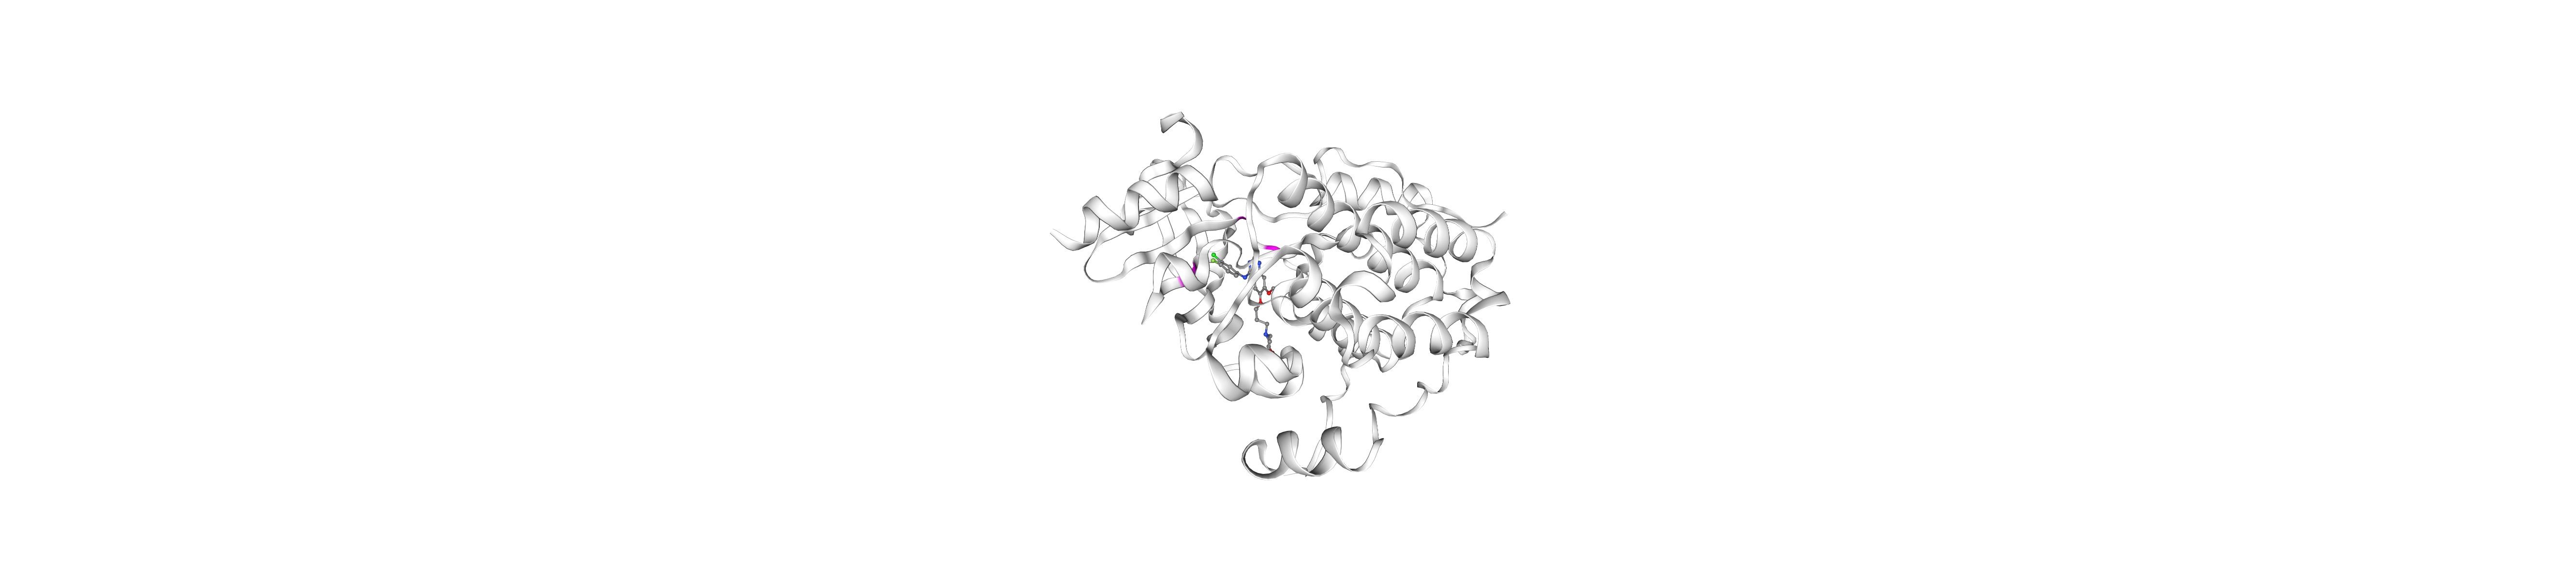

In [37]:
v._display_image()

#### 5. Show all kinase-bound ligands with `rdkit`

Let's take a look at all EGFR-bound ligands using `rdkit`, a popular library for cheminformatics.

In [38]:
def show_ligands(smiles):
    return Chem.Draw.MolsToGridImage(
        [Chem.MolFromSmiles(s) for s in smiles], maxMols=10, molsPerRow=5
    )

Number of ligands bound to kinase #406: 109

Show ligands:

/home/dominique/.local/miniforge3/envs/teachopencadd-review/lib/python3.8/site-packages/rdkit/Chem/Draw/IPythonConsole.py:186: UserWarning: Truncating the list of molecules to be displayed to 10. Change the maxMols value to display more.
  warnings.warn(


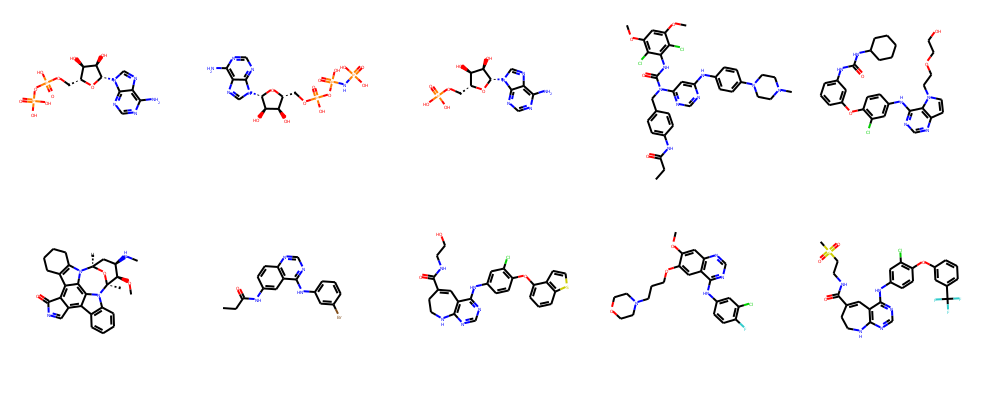

In [39]:
ligands = session.ligands.by_kinase_klifs_id(kinase_klifs_id)
mprint(f"Number of ligands bound to kinase #{kinase_klifs_id}: {len(ligands)}")
mprint(f"Show ligands:")
show_ligands(ligands["ligand.smiles"].to_list())

#### 6. Explore profiling data for Gefitinib

Get ligand KLIFS ID for Gefitinib by which we will query the KLIFS database.

In [40]:
# TODO: Remove when opencadd has by_ligand_expo_id API!
ligand_klifs_id = ligands[ligands["ligand.expo_id"] == ligand_expo_id]["ligand.klifs_id"].iloc[0]
mprint(f"Ligand KLIFS ID for {ligand_expo_id}: {ligand_klifs_id}")
# NBVAL_CHECK_OUTPUT

Ligand KLIFS ID for IRE: 222

Number of bioactivity values for IRE: 252

Show example bioactivities:

|     | kinase.pref_name                       | kinase.uniprot   | ligand.bioactivity_standard_type   | ligand.bioactivity_standard_relation   |   ligand.bioactivity_standard_value | ligand.bioactivity_standard_units   |   ligand.bioactivity_pchembl_value | species.chembl   |
|----:|:---------------------------------------|:-----------------|:-----------------------------------|:---------------------------------------|------------------------------------:|:------------------------------------|-----------------------------------:|:-----------------|
|  48 | Epidermal growth factor receptor erbB1 | P00533           | IC50                               | =                                      |                                0.1  | nM                                  |                              10    | Homo sapiens     |
|  81 | Epidermal growth factor receptor erbB1 | P00533           | IC50                               | =                                      |                                0.15 | nM                                  |                               9.82 | Homo sapiens     |
|  29 | Epidermal growth factor receptor erbB1 | P00533           | IC50                               | =                                      |                                0.17 | nM                                  |                               9.77 | Homo sapiens     |
| 119 | Epidermal growth factor receptor erbB1 | P00533           | Ki                                 | =                                      |                                0.4  | nM                                  |                               9.4  | Homo sapiens     |
|  56 | Epidermal growth factor receptor erbB1 | P00533           | IC50                               | =                                      |                                0.45 | nM                                  |                               9.35 | Homo sapiens     |

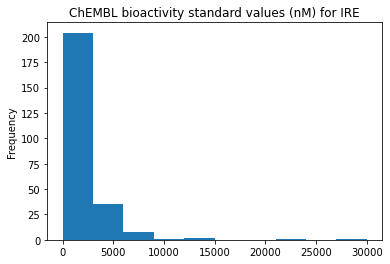

In [43]:
bioactivities = session.bioactivities.by_ligand_klifs_id(ligand_klifs_id)
# TODO: Remove astype when fixed in opencadd
bioactivities = bioactivities.astype({"ligand.bioactivity_standard_value": float})
mprint(f"Number of bioactivity values for {ligand_expo_id}: {len(bioactivities)}")
mprint("Show example bioactivities:")
display(
    Markdown(bioactivities.sort_values("ligand.bioactivity_standard_value").head().to_markdown())
)
bioactivities["ligand.bioactivity_standard_value"].plot(
    kind="hist", title=f"ChEMBL bioactivity standard values (nM) for {ligand_expo_id}"
);

We can see that there are lot of measurements with high bioactivity (low values) and some with no bioactivity (high values). 
We know that the intended target (on-target) of Gefitinib is EFGF (also called epidermal growth factor receptor erbB1). It would be interesting to see now if there are other kinases that have been shown to bind Gefitinib also with high bioactivity (off-targets). Such off-targets are often the reason for the side effects of drugs.

In order to find our off-targets based on the ChEMBL profiling data at hand, we will filter now our bioactivity dataset only for measurements showning high activity using the cutoff `activity_cutoff` and we will print out all measurements for targets that are not EGFR (our potential off-targets).

In [44]:
ACTIVITY_CUTOFF = 100
bioactivities_active = bioactivities[
    bioactivities["ligand.bioactivity_standard_value"] < ACTIVITY_CUTOFF
]
mprint(f"Number of measurements with high activity per kinase:")
n_bioactivities_per_target = (
    bioactivities_active.groupby("kinase.pref_name").size().sort_values(ascending=True)
)
n_bioactivities_per_target.name = "# measurements with high activity"
display(Markdown(n_bioactivities_per_target.to_markdown()))
mprint(f"Off-targets of {ligand_expo_id} based on our profiling data:")
bioactivities_active[
    bioactivities_active["kinase.pref_name"] != "Epidermal growth factor receptor erbB1"
].sort_values(["ligand.bioactivity_standard_value"])

Number of measurements with high activity per kinase:

| kinase.pref_name                              |   # measurements with high activity |
|:----------------------------------------------|------------------------------------:|
| Interleukin-1 receptor-associated kinase 1    |                                   1 |
| Serine/threonine-protein kinase RIPK2         |                                   1 |
| Vascular endothelial growth factor receptor 2 |                                   1 |
| Receptor protein-tyrosine kinase erbB-2       |                                   2 |
| Serine/threonine-protein kinase GAK           |                                   2 |
| Epidermal growth factor receptor erbB1        |                                  70 |

Off-targets of IRE based on our profiling data:

,kinase.pref_name,kinase.uniprot,ligand.bioactivity_standard_type,ligand.bioactivity_standard_relation,ligand.bioactivity_standard_value,ligand.bioactivity_standard_units,ligand.bioactivity_pchembl_value,species.chembl
193,Serine/threonine-protein kinase RIPK2,O43353,IC50,=,3.80,nM,8.42,Homo sapiens
188,Serine/threonine-protein kinase GAK,O14976,Kd,=,7.00,nM,8.15,Homo sapiens
187,Serine/threonine-protein kinase GAK,O14976,Kd,=,13.00,nM,7.89,Homo sapiens
155,Receptor protein-tyrosine kinase erbB-2,P04626,IC50,=,24.00,nM,7.62,Homo sapiens
165,Receptor protein-tyrosine kinase erbB-2,P04626,Ki,=,25.12,nM,7.60,Homo sapiens
250,Vascular endothelial growth factor receptor 2,P35968,IC50,=,48.50,nM,7.31,Homo sapiens
123,Interleukin-1 receptor-associated kinase 1,P51617,Kd,=,69.00,nM,7.16,Homo sapiens


Let's take a look at our off-targets and see if we can rationalize our results from a kinase similarity point of view (similar kinases are likely to bind the same ligand) - we will focus on sequence similarity (aka kinase groups and families) for now. 

Our off-target list contains closely related members of the the tyrosine kinase (TK) group, to which EGFR itself belongs, i.e. ErbB2 and Erb4 (two other members of the EGFR family) and VEGFR/KDR - and two kinases from the related tyrosine-like kinase (TKL) group, i.e. RIPK2 and IRAK1. 

The GAK kinase belongs to the atypical kinases and might not be an obvious off-target when only looking at sequence similarity, but it is another well-known and reported off-target. This is a nice example of how sequence is not the only indicator of protein similarity but that structural similarity plays a very important role as well.

Check out __Talktorial 010__ for more details on binding site similarity and off-target prediction

### Explore random kinase in KLIFS (show example structure and all bound ligands)

This section is intended for you to quickly explore the resources on different kinases in KLIFS. 

First, we define a function that allows us to return (a) all structure-bound ligands in KLIFS plus (b) one random structure for a random kinase or given kinase(s).

In [45]:
def random_kinase_structure(*kinase_names):
    """
    Get one example structure (complex and protein structural data) for one or more kinases plus the SMILES of all bound ligands.

    Parameters
    ----------
    *kinase_names : str
        Kinase names.

    Returns
    -------
    (molcomplex, protein, ligands) : (str, str, list of str)
        Complex structural data, protein structural data, list of ligand SMILES.
    """
    # Get all structures or all structures for a given kinase
    if kinase_names:
        kinase_names = list(kinase_names)
        try:
            structures = session.structures.by_kinase_name(list(kinase_names))
        except ValueError:
            raise ValueError(f"The input kinase(s) {kinase_names} yielded no results.")
    else:
        structures = session.structures.all_structures()
    kinase_klifs_ids = [int(i) for i in structures["kinase.klifs_id"].unique()]
    # Choose random structure
    structure = structures.sample().squeeze()
    structure_klifs_id = structure["structure.klifs_id"]
    mprint(f"Selected kinases: {structure['kinase.klifs_name']}")
    # Get complex structural data
    molcomplex = (
        KLIFS_CLIENT.Structures.get_structure_get_pdb_complex(structure_ID=structure_klifs_id)
        .response()
        .result
    )
    # Get protein structural data
    protein = (
        KLIFS_CLIENT.Structures.get_structure_get_protein(structure_ID=structure_klifs_id)
        .response()
        .result
    )
    # Get all ligands bound to all structures for input kinases
    ligands = KLIFS_CLIENT.Ligands.get_ligands_list(kinase_ID=kinase_klifs_ids).response().result
    mprint(
        f"Chosen KLIFS entry: PDB ID {structure['structure.pdb_id']} "
        f"with chain {structure['structure.chain'] if structure['structure.chain'] else '-'} and "
        f"alternate model {structure['structure.alternate_model'] if structure['structure.alternate_model'] else '-'} "
        f"({structure['species.klifs'].lower()})."
    )
    mprint(f"Number of structure-bound ligands: {len(ligands)}")
    return molcomplex, protein, [ligand.SMILES for ligand in ligands]

Second, we use the function to get data on a random kinase. _Note_: You can specifies one or more kinase of your choosing to narrow down the search space if you want, see `random_kinase_structure(*kinase_names)`.

In [46]:
molcomplex, protein, ligands = random_kinase_structure()

Selected kinases: CDK2

Chosen KLIFS entry: PDB ID 2wip with chain A and alternate model - (human).

Number of structure-bound ligands: 3564

RDKit ERROR: [13:01:14] Explicit valence for atom # 40 O, 4, is greater than permitted
RDKit ERROR: [13:01:14] Explicit valence for atom # 0 O, 4, is greater than permitted
RDKit ERROR: [13:01:14] Explicit valence for atom # 24 O, 4, is greater than permitted
RDKit ERROR: [13:01:14] Explicit valence for atom # 17 O, 4, is greater than permitted
RDKit ERROR: [13:01:14] Explicit valence for atom # 0 O, 4, is greater than permitted
RDKit ERROR: [13:01:14] Explicit valence for atom # 12 O, 4, is greater than permitted
RDKit ERROR: [13:01:14] Explicit valence for atom # 28 O, 4, is greater than permitted
RDKit ERROR: [13:01:14] Explicit valence for atom # 17 O, 4, is greater than permitted
RDKit ERROR: [13:01:14] SMILES Parse Error: syntax error while parsing: Fc1c(c(F)ccc1)-c1cc2c(-c3nc(OC4C[N+H2]CCC4)cnc3)c[nH]c2cc1
RDKit ERROR: [13:01:14] SMILES Parse Error: Failed parsing SMILES 'Fc1c(c(F)ccc1)-c1cc2c(-c3nc(OC4C[N+H2]CCC4)cnc3)c[nH]c2cc1' for input: 'Fc1c(c(F)ccc1)-c1cc2c(-c3nc(OC4C[N+H

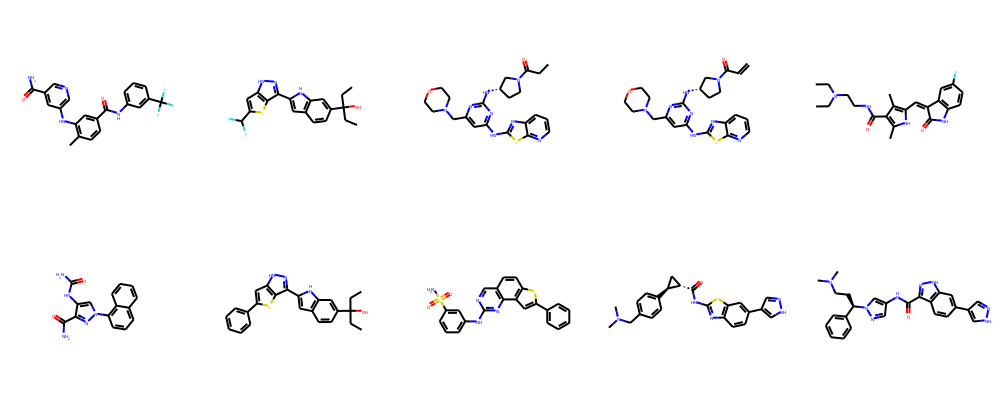

In [47]:
show_ligands(ligands)

In [48]:
v = show_molecule(molcomplex, "pdb")
v

NGLWidget()

In [49]:
v.render_image();

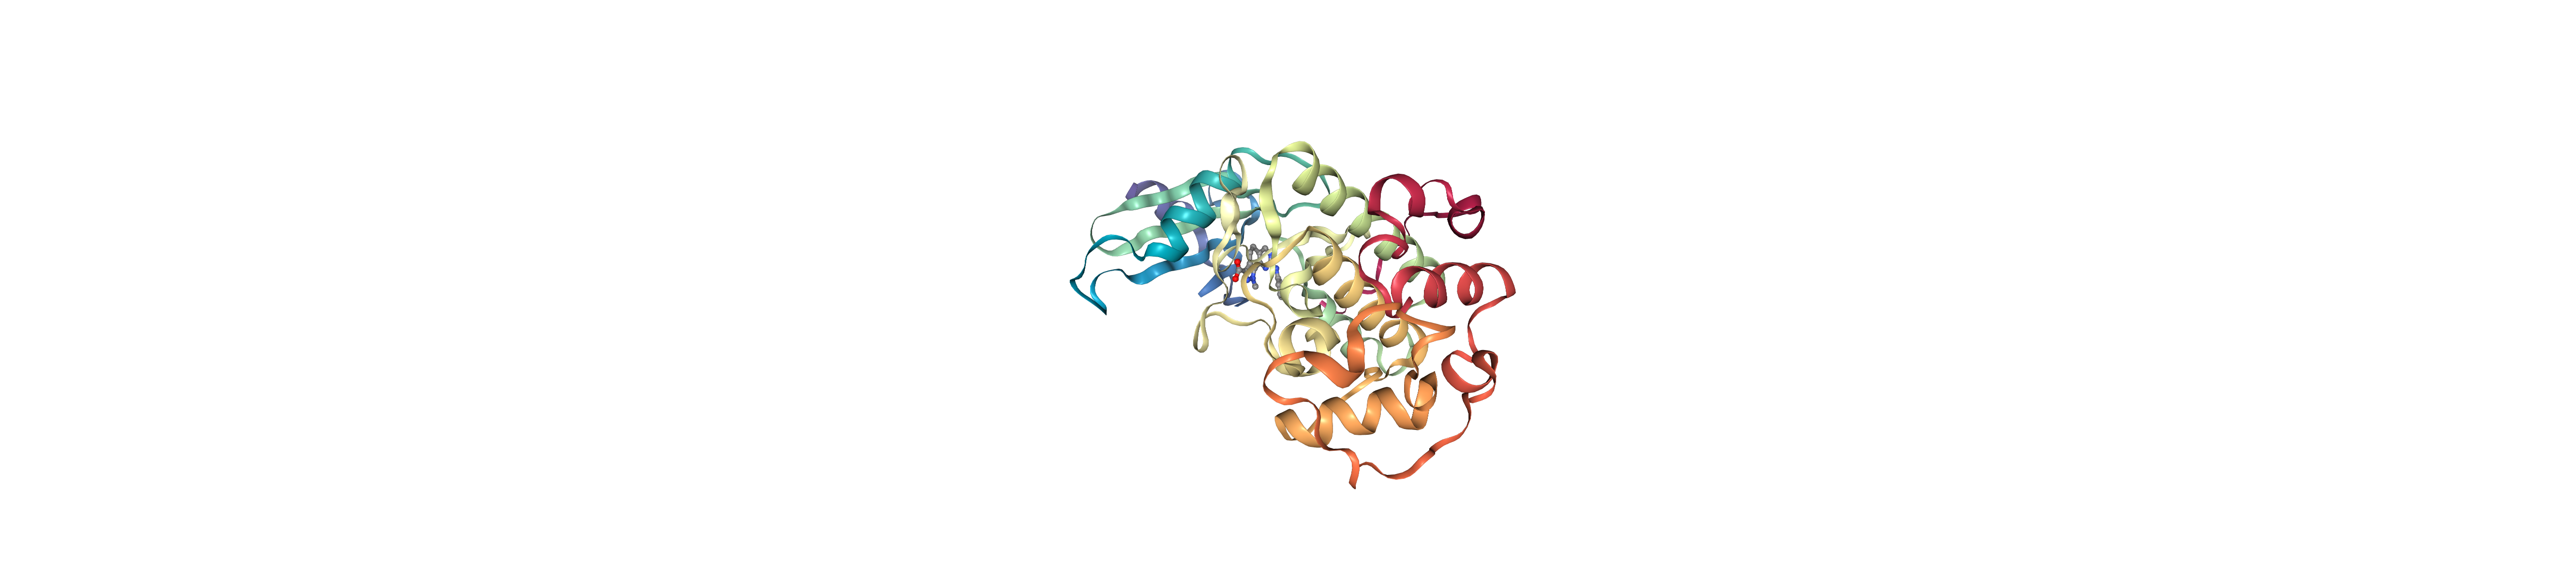

In [50]:
v._display_image()

## Discussion

__TODO__: In this talktorial, we have explored how to interact with the rich kinase resource KLIFS using (a) the KLIFS Swagger API and (b) the KLIFS-dedicated module in `opencadd`. We have started with a query kinase (here: EGFR) and extracted all available interaction fingerprints (IFPs) and investigated off-targets of the EGFR inhibitor Gefitinib based on its profiling data (bioactivity measurements).

## Quiz

- Explain and set in context the following terms: Server, client, API, REST and Swagger.
- Query KLIFS: How many kinases does KLIFS provide for the Abl family? How many structures are available for kinase CDK2?
- Explain how the profiling data of an inhibitor can be used to search for off-targets.